# 感知机

感知机(perceptron)是二分类的线性分类模型，其输入为实例的特征向量，输出为实例的类别，取 +1 和 -1. 感知机对应于输入空间中，将实例划分为正负两类的超平面。为了求出这样一个超平面，首先需要一个基于误分类的损失函数，然后利用梯度下降法，对损失函数进行极小化，求得感知机模型。 感知机学习算法具有简单易于实现的优点，分为原始形式和对偶形式。 感知机预测是用学习得到的感知机模型对新的输入实例进行分类。

为了便于演示，首先导入如下包：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import uniform
from scipy.spatial import ConvexHull

## 2.1 感知机的定义：

假设输入空间（特征空间）是 $\chi \subseteq \text R^n$，输出空间是 $\gamma = \{+1,-1\}$. 输入 $x \in \chi$ 表示实例的特征向量，对应于输入空间（特征空间）的点；输出 $y \in \gamma$ 表示实例的类别。由输入空间到输出空间的如下函数
$$f(x) = \text{sign}(w \cdot x+b)$$
称为感知机. 其中，$w$ 和 $b$ 为感知机模型参数，$w \in \text{R}^n$ 为权值向量，$b \in R$ 为偏置(bias)，$w \cdot x$ 表示 $w$ 和 $x$ 的内积。

感知机有如下几何解释：线性方程
$$w \cdot x + b = 0$$ 
对应于特征空间 $R^n$ 中的一个超平面 $S$，其中 $w$ 是超平面的法向量，$b$ 是超平面的截距. 这个超平面将特征空间划分为两个部分。位于两部分的点（特征向量）分别被分为正、负两类，因此，超平面 $S$ 称为分离超平面. 如下图所示，其中分类超平面为$x_1+x_2-10=0$，$w=[1, 1]^T$，$b=-10$。

Text(0,0.5,'$x_2$')

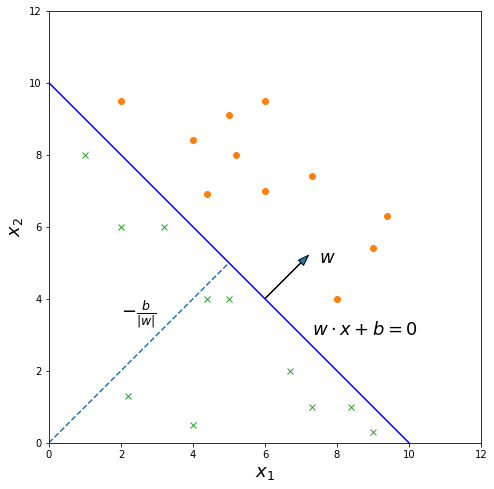

In [2]:
t = np.linspace(0, 10, 10)

p1 = [2, 4, 4.4, 6, 6, 5.2, 5, 7.3, 9.4, 9, 8]
p2 = [9.5, 8.4, 6.9, 7, 9.5, 8, 9.1, 7.4, 6.3, 5.4, 4]

n1 = [1, 3.2, 4.4, 5, 6.7, 2.2, 4, 7.3, 8.4, 9, 2]
n2 = [8, 6, 4, 4, 2, 1.3, 0.5, 1, 1, 0.3, 6]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1.5])
ax.plot(t, -t+10, 'b')
ax.plot([0, 5], [0, 5], '--')
ax.arrow(6,4,1,1,head_width=0.2)

ax.text(2,3.5,r"$-\frac{b}{\|w\|}$", fontsize=18)
ax.text(7.5,5,r"$w$", fontsize=18)
ax.text(7.3,3,r"$w \cdot x+b=0$", fontsize=18)

ax.plot(p1, p2, 'o')
ax.plot(n1, n2, 'x')

ax.axis([0,12,0,12],'equal')
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)


## 2.2 数据集的线性可分性

感知机是一种线性分类器，要想用该方法对数据进行分类，必须要求数据是线性可分的。数据线性可分的定义与存在一个分类超平面将数据集分开等价。该定义的详细数学表达可参看李航老师的《统计学习方法》。从定义可以看出，判断是否线性可分的过程实际上就是寻找感知机的过程。因此从定义出发判断是否线性可分的方法并不适合感知机。

那么如何判断数据是否线性可分呢？

这里需要引入[凸包](https://baike.baidu.com/item/%E5%87%B8%E5%8C%85/179150?fr=aladdin)，凸包（Convex Hull）是一个计算几何（图形学）中的概念。

在一个实数向量空间V中，对于给定集合X，所有包含X的凸集的交集S被称为X的凸包。X的凸包可以用X内所有点(X1，...Xn)的凸组合来构造。

在二维欧几里得空间中，凸包可想象为一条刚好包著所有点的橡皮圈。

用不严谨的话来讲，给定二维平面上的点集，凸包就是将最外层的点连接起来构成的凸多边形，它能包含点集中所有的点。

<img style="float: center;" src="ConvexHull.png" width="40%">
那么如何用凸包判断两类数据集是否线性可分呢？

很简单，如果这两类数据集的凸包不相交就一定是线性可分的。下图就是一个线性可分的例子。
<img style="float: center;" src="example1.png" width="40%">

除了判断线性可分外，凸包在图像领域也有很多用处，例如求轮廓等。求凸包的算法有很多种，由于scipy.spatial中有现成的方法，这里就不再重新实现了。

In [3]:
class Samples:
    def __init__(self, num, min_x, max_x, min_y, max_y):
        self.num = num
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.k = round(uniform(-10, 10))
        self.b = round(uniform(min_y, max_y))
        
        #x为横坐标，y为纵坐标，lab为标签，points为所有点坐标(x,y)的集合
        x, y, lab = [], [], []
        points = []
        for i in range(self.num):
            x.append(round(uniform(self.min_x, self.max_x), 2))
            y.append(round(uniform(self.min_y, self.max_y), 2))
            lab0 = self.__lab(x[-1], y[-1], self.k, self.b)
            if not lab0:
                x[-1] = x[-1] + (self.max_x - self.min_x)/self.num
                lab0 = self.__lab(x[-1], y[-1], self.k, self.b)
            lab.append(lab0)
            points.append([x[-1], y[-1]])
                
        self.x = np.array(x)
        self.y = np.array(y)
        self.points = np.array(points)
        self.lab = np.array(lab).reshape(self.num, 1)

        points1, points2=[], []
        for i in range(self.num):
            if self.lab[i] > 0:
                points1.append([x[i], y[i]])
            else:
                points2.append([x[i], y[i]])
        self.points1 = np.array(points1)
        self.points2 = np.array(points2)
        
        
    #若(x,y)在y=k*x+b上方返回1，在下方返回-1，在直线上返回0
    def __lab(self, x, y, k, b):
        if np.abs(y - k * x - b) <= 0.001:
            return 0
        return np.sign(y - k * x - b)

    def show(self):
        plt.plot(self.points1[:,0], self.points1[:,1], 'ro')
        plt.plot(self.points2[:,0], self.points2[:,1], 'o')
        #t = np.linspace(-5, 5, 10)
        #plt.plot(t, self.k * t + self.b, 'black')

        hull1 = ConvexHull(self.points1)
        hull2 = ConvexHull(self.points2)

        plt.plot(self.points1[hull1.vertices,0], self.points1[hull1.vertices,1], 'g--', lw=2)
        plt.plot(self.points2[hull2.vertices,0], self.points2[hull2.vertices,1], 'y--', lw=2)
        plt.show()

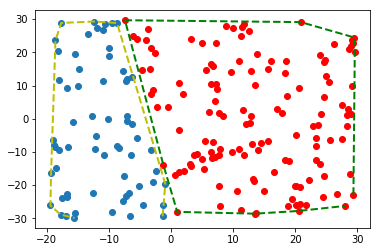

In [4]:
sam = Samples(200,-20,30,-30,30)
sam.show()


## 2.3 感知机的损失函数

所谓的感知机学习，就是根据训练集找到一个能够将正实例点、负实例点完全分开的分离超平面。为了求出这样一个超平面，首先需要一个基于误分类的损失函数，然后利用梯度下降法，对损失函数进行极小化，求得感知机模型。

感知机采用的损失函数是误分类点到超平面的总距离。根据空间中任意一点 $x_0$ 到超平面 $S$ 的距离：

$$\frac{1}{\|w\|}|w\cdot x_0+b|$$

其中，$\|w\|$ 是 $w$ 的 $L_2$ 范数。

由于误分类时 $y_i(w\cdot x_i + b)<0$，因此，误分类点 $x_i$ 到超平面的距离为

$$-\frac{1}{\|w\|}y_i(w\cdot x_i+b)$$

这样，假设超平面 $S$ 的误分类集合为 $M$，那么所有误分类点到超平面 $S$ 的总距离为

$$-\frac{1}{\|M\|}\sum_{x_i \in M}y_i(w\cdot x_i+b)$$

不考虑 $\frac{1}{\|w\|}$，就得到感知机的损失函数。

对于给定的训练数据集

$$T={(x_1,y_1),(x_2,y_2),\ldots,(x_N,y_N)}$$

其中，$x_i \in \chi=\text R^n$，$y_i\in \gamma={+1,-1}$，$i=1,2,\ldots,N$。$M$ 为误分类点集合，感知机 $sign(w\cdot x+b)$ 学习的损失函数定义为

$$L(w,b)=-\sum_{x_i\in M}y_i(w\cdot x_i+b)$$

显然，损失函数 $L(w,b)$ 是非负的。如果没有误分类点，损失值是0。误分类点越少，误分类点离超平面越近，损失函数值就越小。一个特定样本点的损失函数是参数 $w, b$ 的线性函数，在正确分类时是0。因此，给定训练数据集 $T$，损失函数 $L(w,b)$ 是 $w,b$ 的连续可导函数。

## 2.4 感知机的学习算法

感知机学习的问题转化为求解损失函数的最优化问题，最优化的方法是随机梯度下降法(stochastic gradient descent)。主要有两种形式，原始形式和对偶形式。

### 2.4.1 原始形式

首先，任选一个超平面 $w_0,b_0$，然后用梯度下降法不断地极小化损失函数，极小化的过程不是一次使 $M$ 中所有误分类点的梯度下降，而是一次随机选取一个误分类点使其梯度下降。

假设分类点集合 $M$ 是固定的，那么损失函数 $L(w,b)$ 的梯度由
$$\nabla_w L(w,b)=-\sum_{x_i \in M}y_ix_i$$
$$\nabla_b L(w,b)=-\sum_{x_i \in M}y_i$$
给出。

随机选取一个误分类点 $(x_i,y_i)$，对 $w,b$ 进行更新：
$$w=w+\eta y_ix$$
$$b=b+\eta y_i$$
其中 $\eta(0<\eta\leq 1)$ 是步长，也叫做学习率(learning rate)。这样，通过迭代可以期待损失函数 $L(w,b)$ 不断减小，直到为0。

通过以上分析，给出如下算法：

输入：训练数据集 $T={(x_1,y_1),(x_2,y_2),\ldots,(x_N,y_N)}$，其中 $x_i \in \chi = \text R^n$，$y_i \in \gamma = {-1,+1}$，$i=1,2,\ldots,N$；学习率 $\eta(0<\eta\leq 1)$；

输出：$w,b$；感知机模型 $f(x)=\text{sign}(w\cdot x+b)$。

（1）选取初值 $w_0,b_0$；

（2）在训练集中选取数据 $(x_i,y_i)$

（3）如果 $y_i(w\cdot x_i + b) \leq 0$，$w=w+\eta y_i x_i$，$b=b+\eta y_i$

（4）转至（2），直至训练集中没有误分类点。

这种学习算法直观上有如下解释：当一个实例点被误分类，即位于分离超平面的错误一侧时，调整 $w,b$ 的值，使分离超平面向该误分类点的一侧移动，以减小该误分类点与超平面的距离，直至所有误分类点被正确分类。

### 2.4.2 对偶形式

对偶形式基本思想是将 $w$ 和 $b$ 表示为实例 $x_i$ 和标记 $y_i$ 的线性组合的形式，通过求解系数而求得 $w$ 和 $b$。不失一般性，可假设初始值 $w_0,b_0$ 均为0。对误分类点 $(x_i,y_i)$ 通过
$$w=w+\eta y_ix$$
$$b=b+\eta y_i$$
逐步修改 $w,b$，设修改 $n$ 次，则 $w,b$ 关于 $(x_i,y_i)$ 的增量分别是 $\alpha_i y_i x_i$ 和 $\alpha_i y_i$，这里的 $\alpha_i=n_i\eta$。这样，最后学习到的 $w,b$ 可以表示为
$$w\sum_{i=1}^N\eta y_ix_i$$
$$b=\sum_{i=1}^N\eta y_i$$
当 $\eta=1$ 时，表示第 $i$ 个实例点由于误分类而进行更新的次数。实例点更新的次数越多，离分类超平面就越近，也就越难正确分类，对学习的结果影响也就越大。

下面给出对偶形式呃感知机学习算法：

输入：训练数据集 $T={(x_1,y_1),(x_2,y_2),\ldots,(x_N,y_N)}$，其中 $x_i \in \chi = \text R^n$，$y_i \in \gamma = {-1,+1}$，$i=1,2,\ldots,N$；学习率 $\eta(0<\eta\leq 1)$；

输出：$alpha,b$；感知机模型 $f(x)=\text{sign}(\sum_{j=1}^N\alpha_j y_j x_j x+b)$。

其中 $\alpha=(\alpha_1,\alpha_2,\ldots,\alpha_N)^T$。

（1）$\alpha=0$，$b=0$；

（2）在训练集中选取数据 $(x_i,y_i)$；

（3）如果 $y_i(\sum_{j=1}^N\alpha_j y_j x_j \cdot x_i+b)\leq 0$，则 $\alpha_i=\alpha_i+\eta$，$b = b+\eta y_i$；

（4）转至（2）直到没有误分类数据。

对偶形式中训练实例仅以内积的形式出现，为了方便，可以预先将训练集中实例间的内积计算出来并以矩阵的形式存储，这个矩阵就是所谓的 $Gram$ 矩阵

$$G=[x_i \cdot x_j]_{N\times N}$$

以下给出对偶形式的感知机学习算法的实现：

In [5]:
class Perceptron:
    def __init__(self, points, lables):
        self.points = points
        self.lables = lables
        self.num = len(points)
        
        a = np.zeros((self.num, 1), dtype=int)
        eta = 1
        b = 0
        while not (self.__lab(a, b) == self.lables).all():
            for i in range(self.num):
                if self.lables[i] * (np.sum(a * self.lables * self.points * self.points[i]) + b) <= 0:
                    a[i] = a[i] + eta
                    b = b + eta * self.lables[i]
        self.b = b            
        self.w =np.sum(a * self.lables * self.points, axis=0)
        
    def __lab(self, a, b):
        return np.sign(np.sum(np.sum(a * self.lables * self.points, axis=0) * self.points, axis=1) + b).reshape(self.num,1)
        
    def classify(self, point):
        return np.sign(np.sum(self.w * point) + self.b)

### 2.4.3 举个例子

采用上面生成的线性可分数据，求得感知机模型：

In [6]:
per = Perceptron(sam.points, sam.lab)

可以得到感知机的权值向量 $w$ 和偏置 $b$：

In [7]:
per.w,  per.b

(array([125.32,  17.93]), array([416.]))

测试对于给定的样本库中实例点是否能正确分类：

In [8]:
per.classify(per.points[15]),sam.lab[15]

(array([1.]), array([1.]))

画出样本集和分类超平面（绿色），并于生成样本时的分类超平面（黑色）对比：

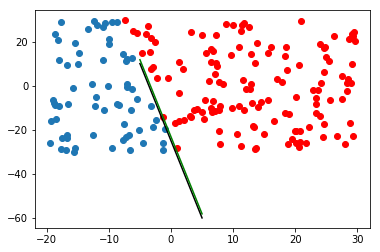

In [9]:
plt.plot(sam.points1[:,0], sam.points1[:,1], 'ro')
plt.plot(sam.points2[:,0], sam.points2[:,1], 'o')

t = np.linspace(-5, 5, 10)
plt.plot(t, sam.k * t + sam.b, 'black')
plt.plot(t, -per.w[0]/per.w[1]*t-per.b/per.w[1],'g')